In [1]:
#Notebook for doing the actual classification


In [2]:
import warnings
warnings.filterwarnings("ignore")
from utils.dataset import AudioDataset, TextDataset, AudioNText
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch
from utils.model import LSTMnet_RnnAtten_latefusion
import numpy as np
from sklearn.metrics import f1_score


In [3]:
train_annotations = '..\\data\\MELD\\train_sent_emo.csv'
val_annotations = '..\\data\\\MELD\\dev_sent_emo.csv'
test_annotations = '..\\data\\MELD\\test_sent_emo.csv'

train_bert = '..\\text_only\\embeddings\\bert_embeddings'
val_bert = '..\\text_only\\embeddings\\bert_embeddings_val'
test_bert = '..\\text_only\\embeddings\\bert_embeddings_test'

train_audio = '..\\data\\MELD\\audio\\wav\\'
val_audio = '..\\data\\MELD\\audio\\wav_dev\\'
test_audio = '..\\data\\MELD\\audio\\wav_test\\'

In [4]:
em = False
audio_train = AudioDataset(train_annotations, train_audio, emotion=em)
audio_val = AudioDataset(val_annotations, val_audio, emotion=em)


text_train = TextDataset(train_annotations, train_bert, emotion=em)
text_val = TextDataset(val_annotations, val_bert, emotion=em)


In [5]:

train = AudioNText(audio_train, text_train)
val = AudioNText(audio_val, text_val)


batch_size = 64

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=False)


train_features, train_labels = next(iter(train_dataloader))

In [6]:
val_dataloader = DataLoader(val, batch_size=len(val), shuffle=False, drop_last=False)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if em:
    weight=torch.tensor([1-1109/9989, 1-271/9989, 1-268/9989, 1-1743/9989, 1-4710/9989, 1-683/9989, 1-1205/9989]).to(device=device)
else:
    weight=torch.tensor([1-2945/9989, 1-2334/9989, 1-4710/9989]).to(device=device)



In [8]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss(weight=weight, label_smoothing=0.0)(input=predictions,target=targets)

In [9]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X1, X2, Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits = model(X1, X2)
        predictions = torch.argmax(output_logits,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100 , f1*100
    return train_step

In [10]:
def make_validate_fnc(model,loss_fnc):
    def validate(X1, X2 ,Y):
        with torch.no_grad():
            model.eval()
            output_logits = model(X1, X2)
            predictions = torch.argmax(output_logits,dim=1)
            
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions, f1*100
    return validate

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMnet_RnnAtten_latefusion(input_dim_a=104, input_dim_b=768, hidden_dim_a=128, hidden_dim_b=128, hidden_dim=128, output_dim=3, num_layers_a=3, num_layers_b=3).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

Number of trainable params:  1223939


In [12]:

OPTIMIZER = torch.optim.Adam(model.parameters(),lr=1e-5, weight_decay=1e-3) #???
train_step = make_train_step(model, loss_fnc, OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)

val_accs = []
losses=[]
val_losses = []
f1s = []
val_f1s= []
epochs = 75 #
best_val_f1 = 0.3
j = False


for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    epoch_f1 = 0
    for idx, (features, labels) in enumerate(train_dataloader):
        X, Y = features, labels
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        text = X_tensor[:,:768]
        audio = X_tensor[:,768:]
        # combined_tensor = torch.cat((audio, text), axis=1)
        loss, acc, f1= train_step(audio,text,Y_tensor)
        epoch_acc += acc*len(features)/len(train)
        epoch_loss += loss*len(features)/len(train)
        epoch_f1 += f1*len(features)/len(train)
    for batch in val_dataloader:
        X_val, Y_val = batch
        break
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
   
    text_val = X_val_tensor[:,:768]
    audio_val = X_val_tensor[:,768:]
    # combined_tensor_val = torch.cat((audio_val, text_val), axis = 1)
 
    val_loss, val_acc, _, val_f1= validate(audio_val, text_val,Y_val_tensor)
    val_accs.append(val_acc.cpu())
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    f1s.append(epoch_f1)
    val_f1s.append(val_f1)
    if val_f1 > best_val_f1:
        torch.save(model.state_dict(), 'model_parameters/interfusion/best-model-parameters-interfusion_sent1.pt')
        best_epoch = epoch
        best_val_f1 = val_f1
        j = True
       
       
    
    print('')
    print(f"Epoch {epoch+1} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%  f1:{f1:.2f}%, val_f1:{val_f1:.2f}%")
    
if j:
    print('saved')


Epoch 1 --> loss:1.1143, acc:31.47%, val_loss:1.0906, val_acc:39.53%  f1:60.00%, val_f1:39.31%

Epoch 2 --> loss:1.1090, acc:33.21%, val_loss:1.0890, val_acc:40.34%  f1:33.33%, val_f1:39.46%

Epoch 3 --> loss:1.1033, acc:35.85%, val_loss:1.0810, val_acc:43.77%  f1:40.00%, val_f1:42.01%

Epoch 4 --> loss:1.1027, acc:36.07%, val_loss:1.0821, val_acc:43.50%  f1:20.00%, val_f1:38.49%

Epoch 5 --> loss:1.0947, acc:38.83%, val_loss:1.0795, val_acc:43.68%  f1:20.00%, val_f1:39.13%

Epoch 6 --> loss:1.0974, acc:38.27%, val_loss:1.0761, val_acc:44.86%  f1:37.50%, val_f1:39.64%

Epoch 7 --> loss:1.0940, acc:40.64%, val_loss:1.0713, val_acc:46.03%  f1:50.00%, val_f1:39.78%

Epoch 8 --> loss:1.0899, acc:41.80%, val_loss:1.0738, val_acc:45.49%  f1:40.00%, val_f1:37.98%

Epoch 9 --> loss:1.0895, acc:42.11%, val_loss:1.0672, val_acc:46.30%  f1:45.83%, val_f1:39.16%

Epoch 10 --> loss:1.0875, acc:43.65%, val_loss:1.0666, val_acc:47.38%  f1:65.00%, val_f1:40.33%

Epoch 11 --> loss:1.0899, acc:43.04%, 

51.49603517596783


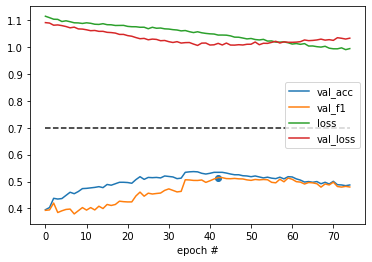

In [13]:
import matplotlib.pyplot as plt
x = range(epochs)

fig, ax = plt.subplots()
ax.set_xlabel('epoch #')
ax.set_ylabel('')
ax.plot(x,np.divide(val_accs,100), label='val_acc')
ax.plot(x,np.divide(val_f1s,100), label='val_f1')
ax.plot(x, losses, label='loss')
ax.plot(x, val_losses, label='val_loss')
ax.scatter(best_epoch, best_val_f1/100)
ax.plot(x, 0.7*np.ones(len(x)), '--', color=(0.1,0.1,0.1))
ax.legend()


print(best_val_f1)


In [14]:
torch.save(model.state_dict(), "model_parameters/interfusion/best-model-parameters-interfusion_sent2.pt")


In [19]:
model.load_state_dict(torch.load("model_parameters/interfusion/best-model-parameters-interfusion_sent1.pt"))

<All keys matched successfully>

In [16]:
audio_test = AudioDataset(test_annotations, test_audio, emotion=em)
text_test = TextDataset(test_annotations, test_bert, emotion=em)

In [17]:
test = AudioNText(audio_test, text_test)
test_dataloader = DataLoader(test, batch_size=len(test), shuffle=False, drop_last=False)

In [20]:



device = 'cpu'
# model_audio.to(device)
# model_text.to(device)
model.to(device)
f1s = []
f1ss = []

for idx, (features, labels) in enumerate(test_dataloader):
    X, Y = features, labels
    X_tensor = torch.tensor(X,device=device).float()
    Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
    text = X_tensor[:,:768]
    audio = X_tensor[:,768:]
    combined_tensor = torch.cat((audio, text), axis=1)
    output_logits = model(audio, text)
    predictions = torch.argmax(output_logits,dim=1)
   
    f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
    f1_ = f1_score(Y.cpu(), predictions.cpu(), average=None, labels=[0,1,2,3,4,5,6])
    f1s.append(f1)
    f1ss.append(f1_)

print(f1)
print(f1_)
# emotions = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}
#  emotions = {'negative':0, 'positive':1, 'neutral':2}

0.49039492476790875
[0.46727829 0.25515464 0.60320856 0.         0.         0.
 0.        ]
